# Imports

In [1]:
import os
import re
import glob
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

import os, sys
from pathlib import Path

# Plotting
import colorama
from colorama import Fore, Style
import seaborn as sns

# For bigfiles
from io import TextIOWrapper
from zipfile import ZipFile

# Ours
from interference_model.quantification import get_interference_rms, get_interference_gpt

# Plotting configurations

In [2]:
# Color rules (based on https://personal.sron.nl/~pault/)
GREEN = "#117733"
TEAL  = "#44AA99"
CYAN = "#88CCEE"
OLIVE = "#CCBB43"
SAND = "#DDCC77"
ROSE   = "#EE6677"
BLUE = "#88CCEE"
MAGENTA = "#AA3377"
GREY = GRAY = "#DDDDDD"

def set_font(size):
    text_font_size = size
    marker_font_size = size
    label_font_size = size
    axes_font_size = size

    plt.rc('text', usetex=True)
    plt.rc('pdf', use14corefonts=True, fonttype=42)
    plt.rc('ps', useafm=True)
    plt.rc('font', size=text_font_size, weight="bold", family='serif', serif='cm10')
    plt.rc('axes', labelsize=axes_font_size,labelweight="bold")    
    plt.rc('xtick', labelsize=label_font_size)    
    plt.rc('ytick', labelsize=label_font_size)    
    plt.rc('legend', fontsize=label_font_size)  
    plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
    plt.rcParams['text.latex.preamble'] = r'\boldmath'
set_font(21)

def save_plot(name):
    plt.savefig(f'./plots/{name}')

def bold(text):
    return r'\textbf{' + text + r'}'
    
lbaf0_pattern = r'\\'
lbaf2_pattern = '.'
set_font(21)

/tmp/ipykernel_46287/4207138001.py:26: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]


# Parsing, util functions

In [3]:
def parse_fio_data(data_path, data):
    if not os.path.exists(f'{data_path}') or \
            os.listdir(f'{data_path}') == []:
        print(f"No data in {data_path}")
        return 0

    for file in glob.glob(f'{data_path}/*'):
        if "bw" in file:
            continue
        with open(file, 'r') as f:
            for index, line in enumerate(f, 1):
                # Removing all fio logs in json file by finding first {
                if line.split()[0] == "{":
                    rows = f.readlines()
                    with open(os.path.join(os.getcwd(), "temp.json"), 'w+') as temp:
                        temp.write(line)
                        temp.writelines(rows)
                    break

        with open(os.path.join(os.getcwd(), "temp.json"), 'r') as temp:
            data[file] = dict()
            data[file] = json.load(temp)
            os.remove(os.path.join(os.getcwd(), "temp.json"))

    return 1

def get_reset_on_io_interference(reset_on_io_data, depth, label_prefix, operation_label, logdepth=False, numjobid=1):
    # alloc
    flows = {'iops':{}, 'p95':{}}
    flow_keys = ['50','75','90','95','99','100']
    for flow in flow_keys:
        flows['iops'][flow] = [None] * depth
        flows['p95'][flow] = [None] * depth
    # parse data
    for key, value in reset_on_io_data.items():
        if "bw" in key:
            continue
        x = int(math.log2(int(value["jobs"][1]["job options"]["iodepth"]))) if logdepth \
            else int(re.search(r'\d+', key).group()) - 1
        if x >= depth:
            continue
        for flow in flow_keys:
            try:
                if f'{label_prefix}flow_{flow}' in key:
                    flows['iops'][flow][x]  = value["jobs"][numjobid][operation_label]["iops_mean"]/1000 
                    flows['p95'][flow][x]   = value["jobs"][numjobid][operation_label]["lat_ns"]["percentile"]["95.000000"]/1000   
            except:
                 if f'{label_prefix}flow_{flow}' in key:
                    flows['iops'][flow][x]  = value["jobs"][1-numjobid][operation_label]["iops_mean"]/1000 
                    flows['p95'][flow][x]   = value["jobs"][1-numjobid][operation_label]["lat_ns"]["percentile"]["95.000000"]/1000              
    # Print RMS
    rms = get_interference_rms(flows['iops']['100'], flows['iops']['50'], \
                               flows['p95']['100'], flows['p95']['50'])
    print(f"Interference RMS 0% - 50% {rms}")
    return flows

def plot_reset_on_io_interference(reset_on_io_data, label, plot_range, plot_jump):
    flow_keys = ['100','99','95','90','75','50']
    colors    = ["#000000", CYAN, MAGENTA, OLIVE, ROSE, GREEN]
    markers   = ['>', 'x', 'o', '<', '^', '*']
    
    
    fig, ax = plt.subplots()
    for flow, color, marker in zip(flow_keys, colors, markers):
        ax.plot(reset_on_io_data['iops'][flow], reset_on_io_data['p95'][flow], 
                                 markersize = 4, marker = marker, label=r"\textbf{" + str(100-int(flow))+ r"\%}", 
                                 color=color, linewidth=2)
    fig.tight_layout()
    ax.grid(which='major', linestyle='dashed', linewidth='1')
    ax.set_axisbelow(True)
    ax.set_ylim(bottom=0, top=plot_range[1])
    ax.set_xlim(left=0, right=plot_range[0])
    ax.set_ylabel(r'\textbf{P95 latency ($\mu$s)}')
    ax.set_xlabel(r'\textbf{Throughput (KIOPS)}')

    ax.xaxis.set_ticks(np.arange(0, plot_range[0]+plot_jump[0], plot_jump[0]))
    ax.yaxis.set_ticks(np.arange(0, plot_range[1]+plot_jump[1], plot_jump[1]))

    return fig, ax

# Figure 3 (reset on I/O interference)

Interference RMS 0% - 50% 0.2432083148220987
Interference RMS 0% - 50% 0.2327728320621907
Interference RMS 0% - 50% 0.04848904296420603


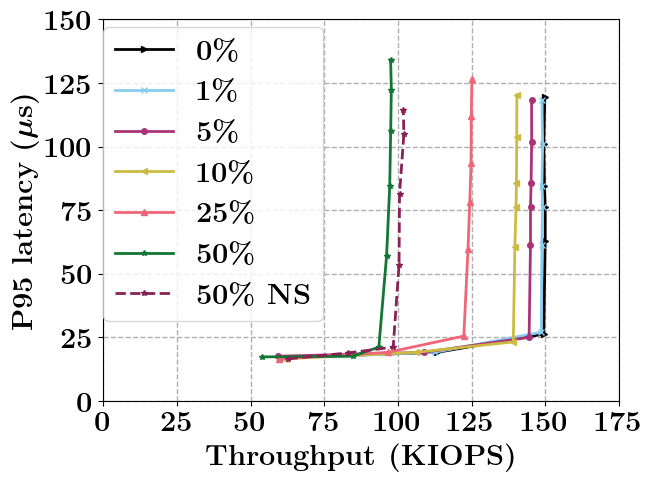

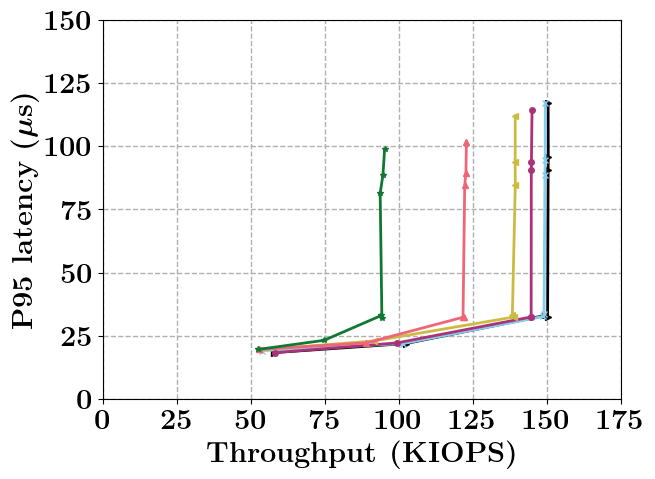

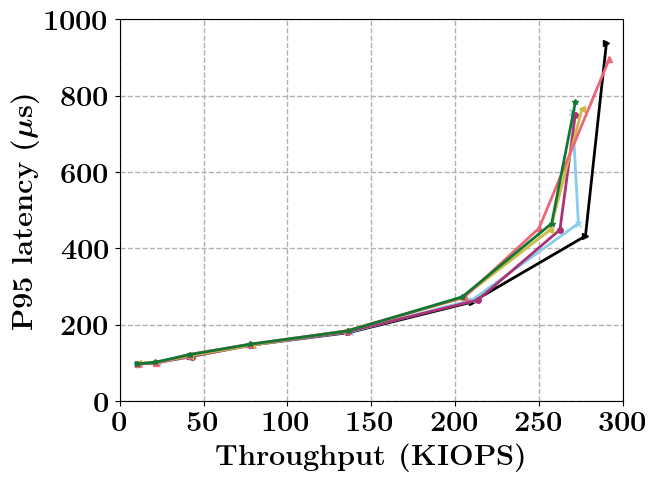

In [4]:
# Reset on write
reset_on_write = dict()
parse_fio_data(f"../zns-command-interference/microbenchmarks/one-namespace/reset-on-write-interference/data", \
               reset_on_write)
reset_on_write = get_reset_on_io_interference(reset_on_write, 8, 'w', 'write')
fig, ax = plot_reset_on_io_interference(reset_on_write, 'write', (175,150), (25,25))
# 50%
write50_iops_namespaces = [62.486982759, 82.841931034, 98.32489655200001, 100.31720689699999, 100.482517241, 101.9595, 101.767558912]
write50_namespaces = [16.512, 18.816, 21.12, 53.504, 81.408, 104.96, 114.176]
ax.plot(write50_iops_namespaces, write50_namespaces, markersize = 4, marker = '*', label=r'\textbf{50\% NS}', 
        color='#882255', linewidth=2, linestyle='--')
# Legend for first plot
ax.legend(loc=(0,0.21))
plt.savefig(f'./plots/interference-micro-reset-on-write.pdf', bbox_inches='tight')


# Reset on Append
reset_on_append = dict()
parse_fio_data(f"../zns-command-interference/microbenchmarks/one-namespace/reset-on-append-interference/data", \
               reset_on_append)
reset_on_append = get_reset_on_io_interference(reset_on_append, 7, 'a', 'finish')
plot_reset_on_io_interference(reset_on_append, 'append', (175,150), (25,25))
plt.savefig(f'./plots/interference-micro-reset-on-append.pdf', bbox_inches='tight')


# Reset on Read
reset_on_read = dict()
parse_fio_data(f"../zns-command-interference/microbenchmarks/one-namespace/reset-on-read-interference/data", \
               reset_on_read)
reset_on_read = get_reset_on_io_interference(reset_on_read, 8, 'r', 'read',True)
plot_reset_on_io_interference(reset_on_read, 'read', (300,1000), (50,200))
plt.savefig(f'./plots/interference-micro-reset-on-read.pdf', bbox_inches='tight')

# Figure 3 (reset on I/O interference)

Interference RMS 0% - 50% 0.260855489038008
Interference RMS 0% - 50% 0.9272720372453901
Interference RMS 0% - 50% 1.1713559194067709


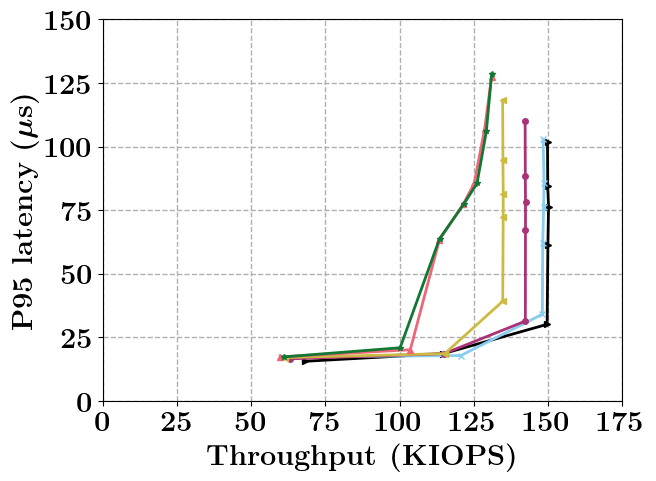

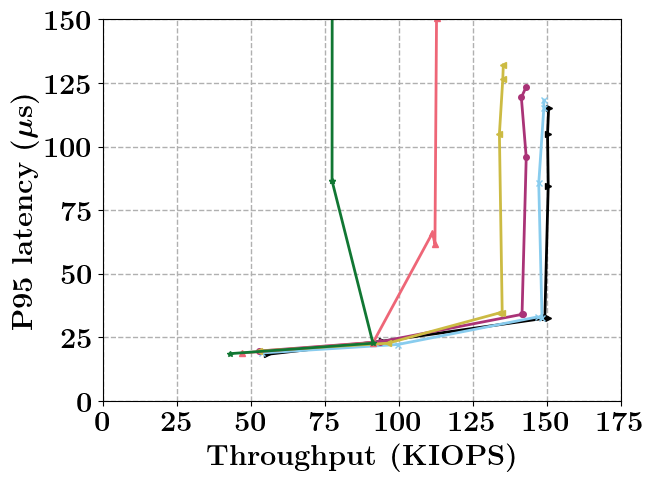

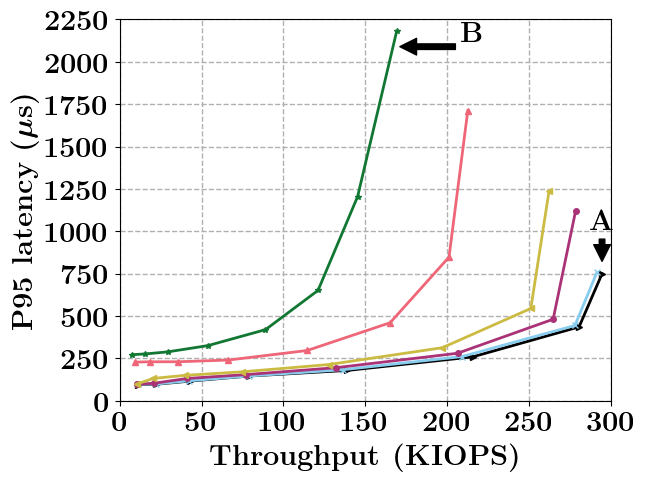

In [5]:
# Finish on Write
finish_on_write = dict()
parse_fio_data(f"../zns-command-interference/microbenchmarks/one-namespace/finish-on-write-interference/data", \
               finish_on_write)
finish_on_write = get_reset_on_io_interference(finish_on_write, 7, 'w', 'finish', numjobid=0)
plot_reset_on_io_interference(finish_on_write, 'write', (175,150), (25,25))
plt.savefig(f'./plots/interference-micro-finish-on-write.pdf', bbox_inches='tight')


# Finish on Append
finish_on_append = dict()
parse_fio_data(f"../zns-command-interference/microbenchmarks/one-namespace/finish-on-append-interference/data", \
               finish_on_append)
finish_on_append = get_reset_on_io_interference(finish_on_append, 7, 'a', 'finish', numjobid=0)
plot_reset_on_io_interference(finish_on_append, 'append', (175,150), (25,25))
plt.savefig(f'./plots/interference-micro-finish-on-append.pdf', bbox_inches='tight')


# Finish on Read
finish_on_read = dict()
parse_fio_data(f"../zns-command-interference/microbenchmarks/one-namespace/finish-on-read-inteference/data", \
               finish_on_read)
finish_on_read = get_reset_on_io_interference(finish_on_read, 8, 'r', 'read',True, numjobid=1)
_, ax = plot_reset_on_io_interference(finish_on_read, 'append', (300,2250), (50,250))
# Annotate
ax.annotate(r'\textbf{B}',
            xy=(finish_on_read['iops']['50'][-1],finish_on_read['p95']['50'][-1]-90), xycoords='data',
            xytext=(55, -0), textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='center', verticalalignment='bottom')

ax.annotate(r'\textbf{A}',
            xy=(finish_on_read['iops']['100'][-1],finish_on_read['p95']['100'][-1]+65), xycoords='data',
            xytext=(0, 20), textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='center', verticalalignment='bottom')
plt.savefig(f'./plots/interference-micro-finish-on-read.pdf', bbox_inches='tight')


# Figure 5 append and write interference on each other.

Interference RMS 0% - 50% 1.2056930871485767
Interference RMS 0% - 50% 1.093092867265227


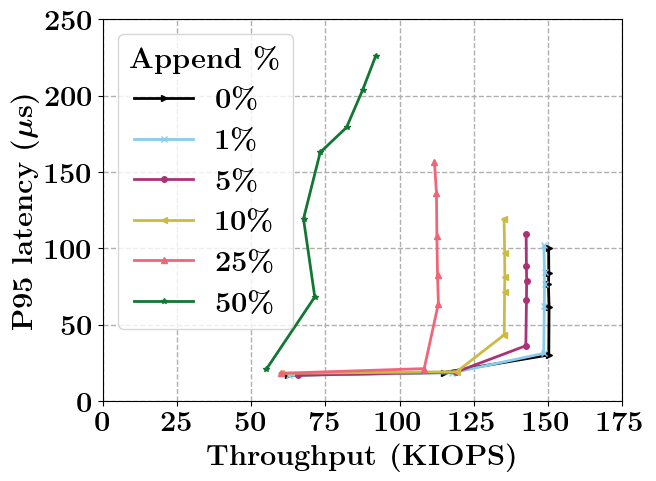

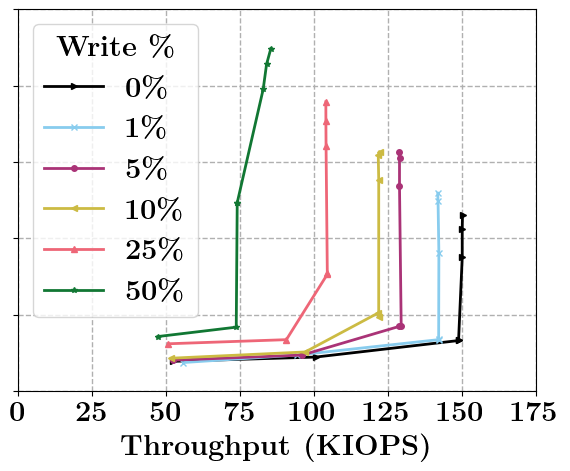

In [6]:
# Append on Wrote
append_on_write = dict()
parse_fio_data(f"../zns-command-interference/microbenchmarks/one-namespace/append-on-write-interference/data", \
               append_on_write)
append_on_write = get_reset_on_io_interference(append_on_write, 7, 'w', 'finish',numjobid=0)
_,ax = plot_reset_on_io_interference(append_on_write, 'write', (175,250), (25,50))
ax.legend(loc='best', title=r'\textbf{Append \%}')
plt.savefig(f'./plots/interference-micro-append-on-write.pdf', bbox_inches='tight')

# Write on Append
write_on_append = dict()
parse_fio_data(f"../zns-command-interference/microbenchmarks/one-namespace/write-on-append-interference/data", \
               write_on_append)
write_on_append = get_reset_on_io_interference(write_on_append, 7, 'a', 'finish')
_,ax = plot_reset_on_io_interference(write_on_append, 'append', (175,250), (25,50))
# Force no ticks
ax.yaxis.set_ticks(np.arange(0, 300, 50), labels=['', '', '', '','',''])
ax.set_ylabel('')
ax.legend(loc='best', title=r'\textbf{Write \%}')
plt.savefig(f'./plots/interference-micro-write-on-append.pdf', bbox_inches='tight')

Interference RMS 0% - 50% 1.1713559194067709
169.09026271899998 2179.072 294.518756303 749.568


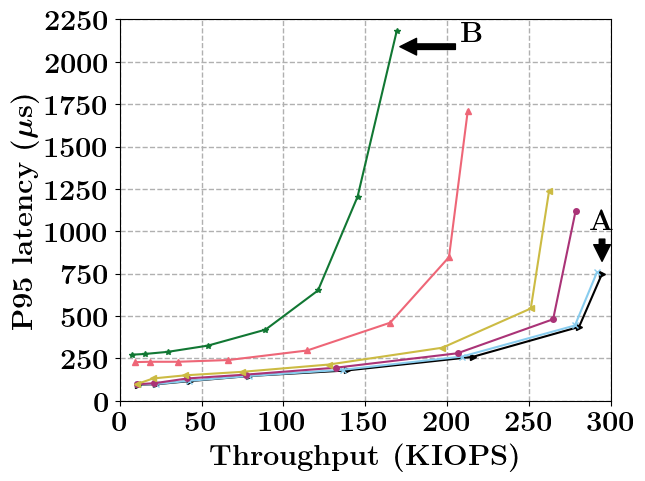

In [7]:
def parse_fio_data(data_path, data):
    if not os.path.exists(f'{data_path}') or \
            os.listdir(f'{data_path}') == []:
        print(f"No data in {data_path}")
        return 0

    for file in glob.glob(f'{data_path}/*'):
        if "bw" in file:
            continue
        with open(file, 'r') as f:
            for index, line in enumerate(f, 1):
                # Removing all fio logs in json file by finding first {
                if line.split() == []:
                    pass
                elif line.split()[0] == "{":
                    rows = f.readlines()
                    with open(os.path.join(os.getcwd(), "temp.json"), 'w+') as temp:
                        temp.write(line)
                        temp.writelines(rows)
                    break

        if Path(os.path.join(os.getcwd(), "temp.json")).exists(): 
            with open(os.path.join(os.getcwd(), "temp.json"), 'r') as temp:
                data[file] = dict()
                data[file] = json.load(temp)
                os.remove(os.path.join(os.getcwd(), "temp.json"))
    return 1

data = dict()
parse_fio_data(f"../zns-command-interference/microbenchmarks/one-namespace/finish-on-read-inteference/data", data)

queue_depths = np.arange(1, 9)

read100 = [None] * len(queue_depths)
read100_iops = [None] * len(queue_depths)
read99 = [None] * len(queue_depths)
read99_iops = [None] * len(queue_depths)
read95 = [None] * len(queue_depths)
read95_iops = [None] * len(queue_depths)
read90 = [None] * len(queue_depths)
read90_iops = [None] * len(queue_depths)
read75 = [None] * len(queue_depths)
read75_iops = [None] * len(queue_depths)
read50 = [None] * len(queue_depths)
read50_iops = [None] * len(queue_depths)
read25 = [None] * len(queue_depths)
read25_iops = [None] * len(queue_depths)

for key, value in data.items():
    if "bw" in key:
        continue
    x = int(math.log2(int(value["jobs"][1]["job options"]["iodepth"])))
    if 'rflow_100' in key:
        read100[x] = value["jobs"][1]["read"]["lat_ns"]["percentile"]["95.000000"]/1000
        read100_iops[x] = value["jobs"][1]["read"]["iops_mean"]/1000
    elif 'rflow_99' in key:
        read99[x] = value["jobs"][1]["read"]["lat_ns"]["percentile"]["95.000000"]/1000
        read99_iops[x] = value["jobs"][1]["read"]["iops_mean"]/1000
    elif 'rflow_95' in key:
        read95[x] = value["jobs"][1]["read"]["lat_ns"]["percentile"]["95.000000"]/1000
        read95_iops[x] = value["jobs"][1]["read"]["iops_mean"]/1000
    elif 'rflow_90' in key:
        read90[x] = value["jobs"][1]["read"]["lat_ns"]["percentile"]["95.000000"]/1000
        read90_iops[x] = value["jobs"][1]["read"]["iops_mean"]/1000
    elif 'rflow_75' in key:
        read75[x] = value["jobs"][1]["read"]["lat_ns"]["percentile"]["95.000000"]/1000
        read75_iops[x] = value["jobs"][1]["read"]["iops_mean"]/1000
    elif 'rflow_50' in key:
        read50[x] = value["jobs"][1]["read"]["lat_ns"]["percentile"]["95.000000"]/1000
        read50_iops[x] = value["jobs"][1]["read"]["iops_mean"]/1000
    elif 'rflow_25' in key:
        read25[x] = value["jobs"][1]["read"]["lat_ns"]["percentile"]["95.000000"]/1000
        read25_iops[x] = value["jobs"][1]["read"]["iops_mean"]/1000


print(f"Interference RMS 0% - 50% {get_interference_rms(read100_iops, read50_iops, read100, read50)}")


fig, ax = plt.subplots()

ax.plot(read100_iops, read100, markersize = 4, marker = '>', label=r'\textbf{0\%}', color="#000000",)
ax.plot(read99_iops, read99, markersize = 4, marker = 'x',   label=r'\textbf{1\%}', color=CYAN)
ax.plot(read95_iops, read95, markersize = 4, marker = 'o',   label=r'\textbf{5\%}', color=MAGENTA)
ax.plot(read90_iops, read90, markersize = 4, marker = '<',   label=r'\textbf{10\%}', color=OLIVE)
ax.plot(read75_iops, read75, markersize = 4, marker = '^',   label=r'\textbf{25\%}', color=ROSE)
ax.plot(read50_iops, read50, markersize = 4, marker = '*',   label=r'\textbf{50\%}', color=GREEN)
# ax.plot(write25_iops, write25, markersize = 4, marker = 'p',   label=" 75% finish")

fig.tight_layout()
ax.grid(which='major', linestyle='dashed', linewidth='1')
ax.set_axisbelow(True)
# ax.legend(loc='best', handles=handles)
# ax.legend(loc='best', title=r'\textbf{Finish \%}')
ax.set_ylim(bottom=0, top=150)
ax.set_xlim(left=0, right=175)

ax.yaxis.set_ticks(np.arange(0, 2400, 250))
ax.xaxis.set_ticks(np.arange(0, 350, 50))

ax.set_ylabel(r'\textbf{P95 latency ($\mu$s)}')
ax.set_xlabel(r'\textbf{Throughput (KIOPS)}')

ax.annotate(r'\textbf{B}',
            xy=(read50_iops[-1],read50[-1]-90), xycoords='data',
            xytext=(55, -0), textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='center', verticalalignment='bottom')

ax.annotate(r'\textbf{A}',
            xy=(read100_iops[-1],read100[-1]+65), xycoords='data',
            xytext=(0, 20), textcoords='offset points',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='center', verticalalignment='bottom')


print(read50_iops[-1],read50[-1], read100_iops[-1],read100[-1] )




plt.savefig('./plots/interference-micro-finish-on-read.pdf', bbox_inches='tight')

# Figure 6

In [8]:
# Data
diff_old = np.array([
     [0.000,0.000,1.093,0.072,0.562],
     [0.000,0.000,0.076,0.022,0.259],
     [1.206,0.941,0.000,0.012,0.187],
     [0.241,0.049,0.233,0.000,0.000],
     [0.261,1.171,0.261,0.000,0.000],
 ])

x_labels = ['Write', 'Read', 'Append', 'Reset', 'Finish']
y_labels    = [x + ' on' for x in ['Write', 'Read', 'Append', 'Reset', 'Finish']]

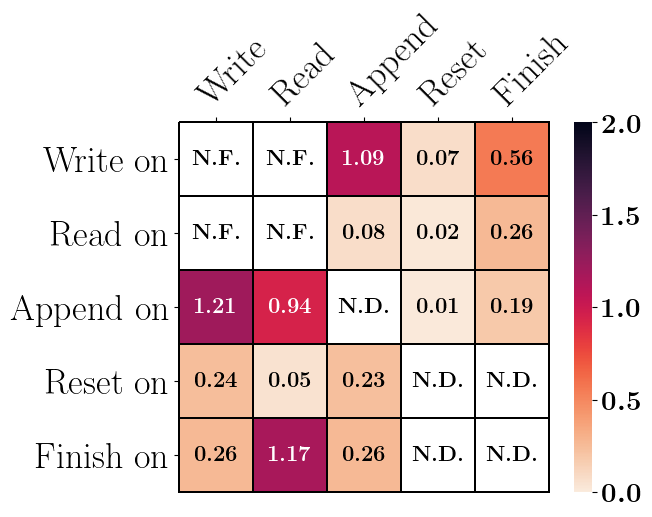

In [9]:
fig, ax = plt.subplots()
heatmap_axis_tick_font_size=26
heatmap_data_tag_size=16
# Plot heatmap
cmap = sns.color_palette('rocket_r', as_cmap=True).copy()
cmap.set_under('#88CCEE')
ax = sns.heatmap(diff_old, 
                 linewidth=0.1, 
                 xticklabels=False, 
                 cmap=cmap, 
                 mask=(diff_old <= 0), 
                 yticklabels=False, 
                 clip_on=False, 
                 # cbar_kws={'shrink': 0.8, 'extend': 'min', 'extendrect': True, 'format': '%d Blocks (512B)'}, 
                 square=True, 
                 cbar=True, 
                 vmin=0,
                 vmax=2,
                 linecolor='black',  annot_kws={"size": 20})
cbar = ax.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=20)

# Set axis labels
ax.set_xticks([x+0.5 for x in np.arange(len(x_labels))],
                labels=x_labels,
                fontsize=heatmap_axis_tick_font_size)
ax.xaxis.set_label_position('top') 
ax.xaxis.tick_top()
ax.set_yticks([x+0.5 for x in np.arange(len(y_labels))],
                labels=y_labels,
                fontsize=heatmap_axis_tick_font_size)
plt.setp(ax.get_xticklabels(),
            rotation=45,
            ha="left",
            rotation_mode="anchor")

# Annotate not known values and set appropriate colors
for i in range(len(diff_old)):
    for j in range(len(diff_old[0])):
        text = round(diff_old[i][j], 2)
        if diff_old[i][j] >= 0.9:
             color = 'w'
             text = r"\textbf{" + str(text) + r"}"
        elif diff_old[i][j] == 0:
             color = 'black'
             if  i < 2:
                 text = r"\textbf{N.F.}"
             else:
                 text = r'\textbf{N.D.}'
        else:
             color = 'black'
             text = r"\textbf{" + str(text) + r"}"
        text = ax.text(j+0.5,
                        i+0.5,
                        text,
                        ha="center",
                        va="center",
                        color=color,
                        fontsize=heatmap_data_tag_size)


plt.savefig('./plots/interference-micro-heatmap.pdf', bbox_inches='tight')

# Figure 7

-------------------------------------------------------------------------------------
Config          reset_lat_16-write_ratio_200000 WRITE Interference RMS    2.052112001398586
Config          reset_lat_16-write_ratio_200000 RESET Interference RMS    1.770324634046114
Config          reset_lat_16-write_ratio_200000 Interference RMS          1.911218317722350
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
Config           reset_lat_16-write_ratio_20000 WRITE Interference RMS    2.020065359043080
Config           reset_lat_16-write_ratio_20000 RESET Interference RMS    1.829205396966171
Config           reset_lat_16-write_ratio_20000 Interference RMS          1.924635378004626
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
Config          re

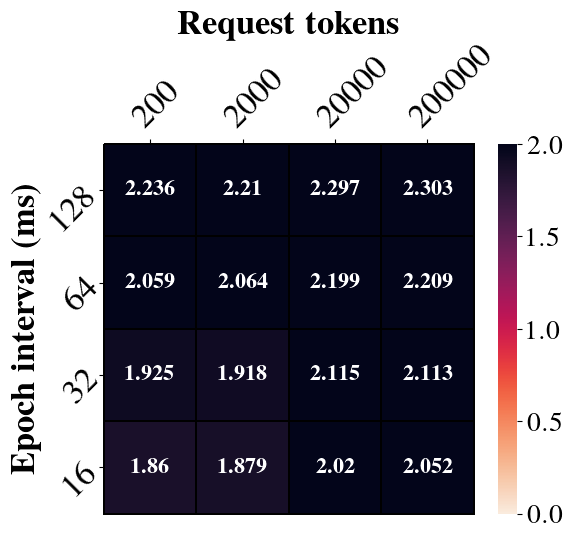

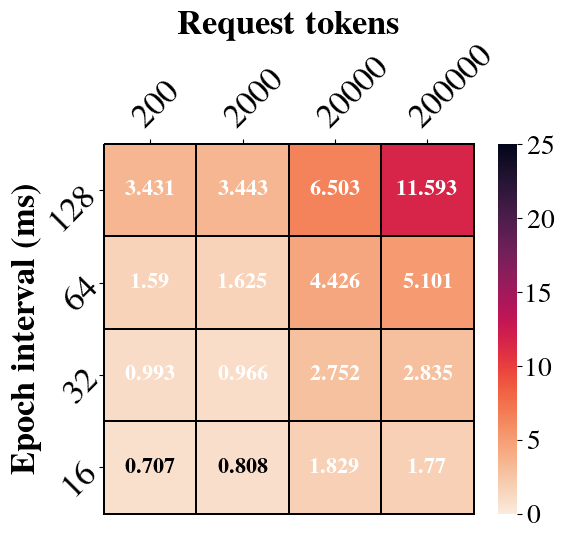

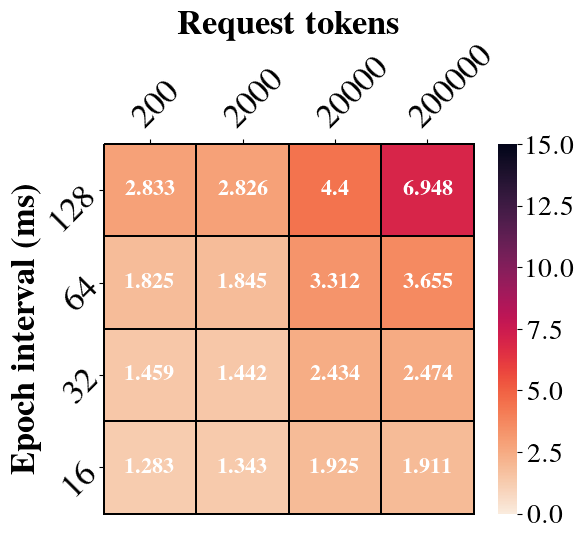

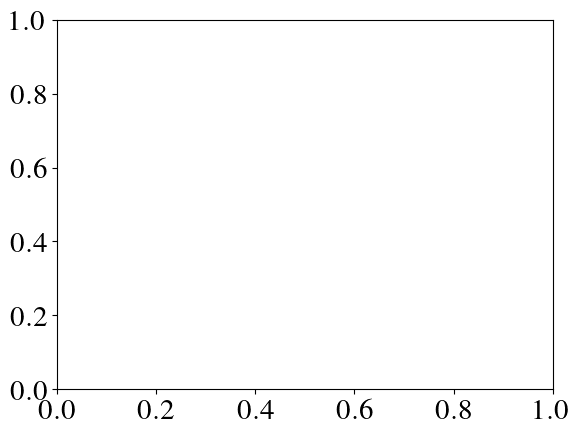

In [10]:
# TODO: retrieve these values from ZenFS tracing for final calculation
WRITE_INTERFERENCE_GAMMA = 0.5
RESET_INTERFERENCE_DELTA = 0.5

RESET_ON_WRITE_RMS = 0.241 # From our benchmark reset-on-write-interference, the retrieved RMS value
WRITE_ON_RESET_RMS = 0.072 # From our benchmark write-on-reset-interference, the retrieved RMS value

# Switch to Type 1 Fonts.
plt.rcParams['text.usetex'] = True
plt.rc('font', **{'family': 'serif', 'serif': ['Times']})

matplotlib_color = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5']
m_color_index = 0

matplotlib_colors = [
    'blue', 'green', 'red', 'cyan', 'magenta', 'yellw', 'white'
]

dot_style = [
    '+',
    'X',
    'o',
    'v',
    's',
    'P',
]

# Global parameters
linewidth = 4
markersize = 15

datalabel_size = 36
datalabel_va = 'bottom'
axis_tick_font_size = 46
axis_label_font_size = 52
legend_font_size = 46

heatmap_axis_tick_font_size = 26
heatmap_data_tag_size = 16

def parse_fio_data(data_path, data):
    if not os.path.exists(f'{data_path}') or \
            os.listdir(f'{data_path}') == []:
        print(f"No data in {data_path}")
        return 0
    
    for file in glob.glob(f'{data_path}/*'):
        if "bw" in file:
            continue
        with open(file, 'r') as f:
            for index, line in enumerate(f, 1):
                # Removing all fio logs in json file by finding first {
                if line.split()[0] == "{":
                    rows = f.readlines()
                    with open(os.path.join(os.getcwd(), "temp.json"), 'w+') as temp:
                        temp.write(line)
                        temp.writelines(rows)
                    break

        if Path(os.path.join(os.getcwd(), "temp.json")).exists(): 
            with open(os.path.join(os.getcwd(), "temp.json"), 'r') as temp:
                data[file] = dict()
                data[file] = json.load(temp)
                os.remove(os.path.join(os.getcwd(), "temp.json"))

    return 1

def init_baseline(baseline):
    val = baseline[0]

    i = 0
    for value in baseline:
        baseline[i] = val
        i += 1

def parse_write_baseline(write_baseline_iops, write_baseline_lat):
     for conf_key, conf_value in data.items():

        for key, value in conf_value.items():
            if conf_key == "baseline":
                if "reset_baseline" in key:
                    continue
                elif "bw" in key:
                    continue
                else:
                    head, tail = os.path.split(key)
                    numjobs = int(re.search(r'\d+', tail).group())
                    write_baseline_iops[numjobs - 1] =  value["jobs"][0]["finish"]["iops_mean"]/1000
                    write_baseline_lat[numjobs - 1] = value["jobs"][0]["finish"]["lat_ns"]["percentile"]["95.000000"]/1000
            else:
                continue

def parse_reset_baseline(reset_baseline_iops, reset_baseline_write):
     for conf_key, conf_value in data.items():

        for key, value in conf_value.items():
            if conf_key == "baseline":
                if "reset_baseline" in key:
                    reset_baseline_iops[0] = value["jobs"][1]["ZNS Reset"]["iops_mean"]
                    reset_baseline_lat[0] = value["jobs"][1]["ZNS Reset"]["lat_ns"]["percentile"]["95.000000"]/1000 # TODO: change this to clat after rerunning
                    init_baseline(reset_baseline_iops)
                    init_baseline(reset_baseline_lat)

                    return
                else:
                    continue
            else:
                continue


def get_matrix_col(val):
    """Get the config index for the col which represents the reset latency"""
    match(val):
        case 16:
            return 3
        case 32:
            return 2
        case 64:
            return 1
        case 128:
            return 0

def get_matrix_row(val):
    """Get the config index for the row which represents the write ratio"""
    match(val):
        case 200:
            return 0
        case 2000:
            return 1
        case 20000:
            return 2
        case 200000:
            return 3
        
def generate_heatmap(config_interference, job, max):
    reset_latency = [16, 32, 64, 128]
    write_ratio    = [200, 2000, 20000, 200000]

    cmap = sns.color_palette('rocket_r', as_cmap=True).copy()
    cmap.set_under('#88CCEE')
    
    ax = sns.heatmap(config_interference, 
                    linewidth=0.1, 
                    xticklabels=True, 
                    cmap=cmap, 
                    yticklabels=True, 
                    clip_on=False, 
                    # cbar_kws={'shrink': 0.8, 'extend': 'min', 'extendrect': True, 'format': '%d Blocks (512B)'}, 
                    square=True, 
                    cbar=True, 
                    vmin=0,
                    vmax=max,
                    linecolor='black',  annot_kws={"size": 20})

    ax.set_xticks([x+0.5 for x in np.arange(len(write_ratio))])
    ax.set_xticklabels(labels=write_ratio,
                fontsize=25)
    ax.xaxis.set_label_position('top') 
    ax.xaxis.tick_top()

    ax.set_yticks([x+0.5 for x in np.arange(len(reset_latency))])
    ax.set_yticklabels(labels=reset_latency[::-1],
                    fontsize=25)

    plt.setp(ax.get_xticklabels(),
                rotation=45,
                ha="left",
                rotation_mode="anchor")
    
    plt.setp(ax.get_yticklabels(),
                rotation=45,
                ha="right",
                rotation_mode="anchor")
    
    ax.set_ylabel(r"\textbf{Epoch interval (ms)}", fontsize=25)
    ax.set_xlabel(r"\textbf{Request tokens}", fontsize=25)
    
    for i in range(len(config_interference)):
        for j in range(len(config_interference[0])):
            text = round(config_interference[i][j], 3)
            text = r'\textbf{' + str(text) + '}'
            if config_interference[i][j] >= 0.9:
                color = 'w'
            elif config_interference[i][j] == 0:
                color = 'black'
            else:
                color = 'black'
            text = ax.text(j+0.5,
                            i+0.5,
                            text,
                            ha="center",
                            va="center",
                            color=color,
                            fontsize=heatmap_data_tag_size)

    cbar = ax.collections[0].colorbar
    # here set the labelsize by 20
    cbar.ax.tick_params(labelsize=20)

    plt.savefig(f"{file_path}/figures/configuration-interference-{job}.pdf", bbox_inches="tight")
    plt.savefig(f"{file_path}/figures/configuration-interference-{job}.png", bbox_inches="tight")
    fig, ax = plt.subplots()

file_path = '../zinc-benchmarks/zinc-configuration'

data = dict()
for dir in glob.glob(f'{file_path}/*'):
    dir = dir.split('/')[-1]
    if dir == "data":
        data["baseline"] = dict()
        parse_fio_data(f"{file_path}/{dir}", data["baseline"])
    elif "data" in dir:
        config = re.findall(r'\d+', dir)
        config_string = f"reset_lat_{config[0]}-write_ratio_{config[1]}"
        data[config_string] = dict()
        data[config_string]["reset_limit_val"] = config[0]
        data[config_string]["write_ratio_val"] = config[1]
        parse_fio_data(f"{file_path}/{dir}", data[config_string])

os.makedirs(f"{file_path}/figures", exist_ok=True)

queue_depths = np.arange(1, 8)
lowest_interference = (None, None)

reset_baseline_iops = [None] * len(queue_depths)
reset_baseline_lat = [None] * len(queue_depths)
write_baseline_iops = [None] * len(queue_depths)
write_baseline_lat = [None] * len(queue_depths)
config_reset_limit = []
config_write_ratio = []
config_interference = np.zeros(shape=(4, 4))
config_interference_write = np.zeros(shape=(4, 4))
config_interference_reset = np.zeros(shape=(4, 4))

parse_write_baseline(write_baseline_iops, write_baseline_lat)
parse_reset_baseline(reset_baseline_iops, reset_baseline_lat)

for conf_key, conf_value in data.items():
    write_iops = [None] * len(queue_depths)
    write_lat = [None] * len(queue_depths)
    reset_iops = [None] * len(queue_depths)
    reset_lat = [None] * len(queue_depths)

    for key, value in conf_value.items():
        if conf_key == "baseline":
           continue
        elif "reset_limit_val" in key or "write_ratio_val" in key:
            continue
        else:
            head, tail = os.path.split(key)
            numjobs = int(re.search(r'\d+', tail).group())
            x = numjobs - 1
            write_iops[x] = value["jobs"][2]["finish"]["iops_mean"]/1000
            write_lat[x] = value["jobs"][2]["finish"]["clat_ns"]["percentile"]["95.000000"]/1000
            reset_iops[x] = value["jobs"][1]["ZNS Reset"]["iops_mean"]
            reset_lat[x] = value["jobs"][1]["ZNS Reset"]["clat_ns"]["percentile"]["95.000000"]/1000

    # While debugging skip all that are ongoing and don't have all data
    if not None in write_iops:
        write_interference = get_interference_rms(write_baseline_iops, write_iops, write_baseline_lat, write_lat)
        reset_interference = get_interference_rms(reset_baseline_iops, reset_iops, reset_baseline_lat, reset_lat)

        print("-------------------------------------------------------------------------------------")
        print(f"Config {conf_key: >40} WRITE Interference RMS {write_interference: >20.15f}")
        print(f"Config {conf_key: >40} RESET Interference RMS {reset_interference: >20.15f}")

        interference = WRITE_INTERFERENCE_GAMMA * write_interference + RESET_INTERFERENCE_DELTA * reset_interference
        print(f"Config {conf_key : >40} Interference RMS {interference : >26.15f}")
        print("-------------------------------------------------------------------------------------")

        config_interference[get_matrix_col(int(conf_value["reset_limit_val"]))][get_matrix_row(int(conf_value["write_ratio_val"]))] = interference
        config_interference_write[get_matrix_col(int(conf_value["reset_limit_val"]))][get_matrix_row(int(conf_value["write_ratio_val"]))] = write_interference
        config_interference_reset[get_matrix_col(int(conf_value["reset_limit_val"]))][get_matrix_row(int(conf_value["write_ratio_val"]))] = reset_interference

        inter = lowest_interference[1]
        if inter == None:
            lowest_interference = (conf_key, interference)
        elif interference < inter:
                lowest_interference = (conf_key, interference)

        fig, ax = plt.subplots()

        ax.plot(write_baseline_iops, write_baseline_lat, markersize = 4, marker = '>', label="   0% reset")
        ax.plot(write_iops, write_lat, markersize = 4, marker = '*', label=" 50% reset")

        fig.tight_layout()
        ax.grid(which='major', linestyle='dashed', linewidth='1')
        ax.set_axisbelow(True)
        # ax.legend(loc='best', handles=handles)
        ax.legend(loc='best')
        ax.set_ylim(bottom=0, top=140)
        ax.set_xlim(left=0)
        ax.set_ylabel("p95 write Latency (usec)")
        ax.set_xlabel("Total IOPS (x1000)")
        plt.savefig(f"{file_path}/figures/loaded_write_latency-{conf_key}.pdf", bbox_inches="tight")
        plt.savefig(f"{file_path}/figures/loaded_write_latency-{conf_key}.png", bbox_inches="tight")
        plt.clf()
        plt.close()

print("\n=====================================================================================")
print(f"{Fore.GREEN}Lowest{Style.RESET_ALL} {lowest_interference[0] : >40} Interference RMS {lowest_interference[1]:>26.15f}")


generate_heatmap(config_interference_write, "write", 2)
generate_heatmap(config_interference_reset, "reset", 25)
generate_heatmap(config_interference, "combined", 15)

-------------------------------------------------------------------------------------
mq-deadline WRITE Interference RMS    0.174729658656460
mq-deadline RESET Interference RMS    0.162540682758875
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
Config          reset_lat_16-write_ratio_200000 WRITE Interference RMS    0.140006115007056
Config          reset_lat_16-write_ratio_200000 RESET Interference RMS    1.770324634046114
Config          reset_lat_16-write_ratio_200000 Interference RMS          0.955165374526585
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
Config           reset_lat_16-write_ratio_20000 WRITE Interference RMS    0.149100605263094
Config           reset_lat_16-write_ratio_20000 RESET Interference RMS    1.82920539696617

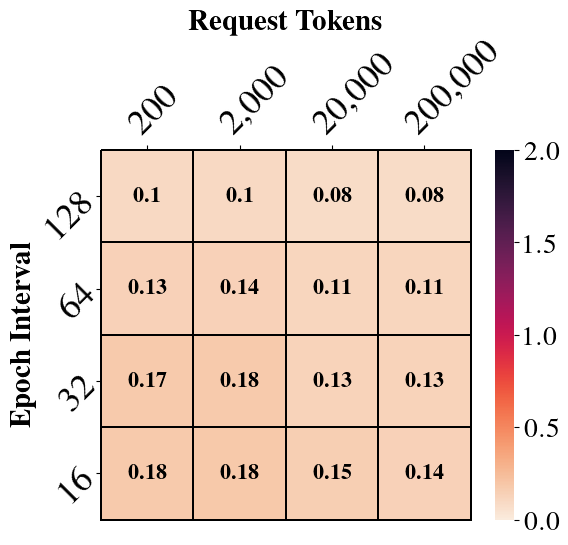

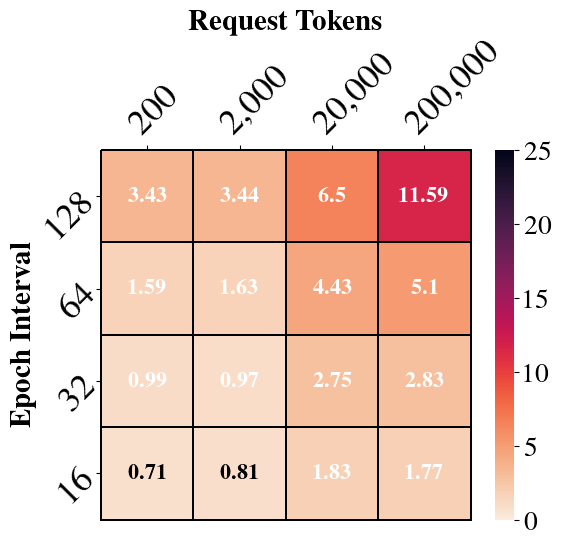

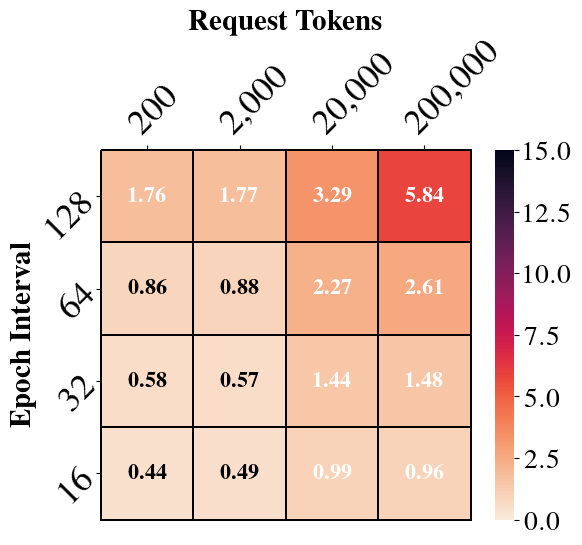

In [11]:
# TODO: retrieve these values from ZenFS tracing for final calculation
WRITE_INTERFERENCE_GAMMA = 0.5
RESET_INTERFERENCE_DELTA = 0.5

RESET_ON_WRITE_RMS = 0.241 # From our benchmark reset-on-write-interference, the retrieved RMS value
WRITE_ON_RESET_RMS = 0.072 # From our benchmark write-on-reset-interference, the retrieved RMS value

def parse_fio_data(data_path, data):
    if not os.path.exists(f'{data_path}') or \
            os.listdir(f'{data_path}') == []:
        print(f"No data in {data_path}")
        return 0
    
    for file in glob.glob(f'{data_path}/*'):
        if "bw" in file:
            continue
        with open(file, 'r') as f:
            for index, line in enumerate(f, 1):
                # Removing all fio logs in json file by finding first {
                if line.split()[0] == "{":
                    rows = f.readlines()
                    with open(os.path.join(os.getcwd(), "temp.json"), 'w+') as temp:
                        temp.write(line)
                        temp.writelines(rows)
                    break

        if Path(os.path.join(os.getcwd(), "temp.json")).exists(): 
            with open(os.path.join(os.getcwd(), "temp.json"), 'r') as temp:
                data[file] = dict()
                data[file] = json.load(temp)
                os.remove(os.path.join(os.getcwd(), "temp.json"))

    return 1

def init_baseline(baseline):
    val = baseline[0]

    i = 0
    for value in baseline:
        baseline[i] = val
        i += 1

def parse_write_baseline(write_baseline_iops, write_baseline_lat, mqddl_iops, mqddl_lat, mqddl50_iops, mqddl50_lat,
                          mqddl_reset_iops, mqddl_reset_lat, zinc_baseline_iops, zinc_baseline_lat):
     for conf_key, conf_value in data.items():

        for key, value in conf_value.items():
            if conf_key == "baseline":
                if "reset_baseline" in key:
                    continue
                elif "bw" in key:
                    continue
                elif "50-mq_deadline" in key:
                    head, tail = os.path.split(key)
                    numjobs = int(re.search(r'\d+', tail).group())
                    mqddl50_iops[numjobs - 1] =  value["jobs"][2]["finish"]["iops_mean"]/1000
                    mqddl50_lat[numjobs - 1] = value["jobs"][2]["finish"]["lat_ns"]["percentile"]["95.000000"]/1000
                    mqddl_reset_iops[numjobs - 1] = value["jobs"][1]["ZNS Reset"]["iops_mean"]
                    mqddl_reset_lat[numjobs - 1] = value["jobs"][1]["ZNS Reset"]["lat_ns"]["percentile"]["95.000000"]/1000
                elif "100-mq_deadline" in key:
                    head, tail = os.path.split(key)
                    numjobs = int(re.search(r'\d+', tail).group())
                    mqddl_iops[numjobs - 1] =  value["jobs"][0]["finish"]["iops_mean"]/1000
                    mqddl_lat[numjobs - 1] = value["jobs"][0]["finish"]["lat_ns"]["percentile"]["95.000000"]/1000
                elif "100-zinc" in key:
                    head, tail = os.path.split(key)
                    numjobs = int(re.search(r'\d+', tail).group())
                    zinc_baseline_iops[numjobs - 1] =  value["jobs"][0]["finish"]["iops_mean"]/1000
                    zinc_baseline_lat[numjobs - 1] = value["jobs"][0]["finish"]["lat_ns"]["percentile"]["95.000000"]/1000
                else:
                    head, tail = os.path.split(key)
                    numjobs = int(re.search(r'\d+', tail).group())
                    write_baseline_iops[numjobs - 1] =  value["jobs"][0]["finish"]["iops_mean"]/1000
                    write_baseline_lat[numjobs - 1] = value["jobs"][0]["finish"]["lat_ns"]["percentile"]["95.000000"]/1000
            else:
                continue

def parse_reset_baseline(reset_baseline_iops, reset_baseline_write):
     for conf_key, conf_value in data.items():

        for key, value in conf_value.items():
            if conf_key == "baseline":
                if "reset_baseline" in key:
                    reset_baseline_iops[0] = value["jobs"][1]["ZNS Reset"]["iops_mean"]
                    reset_baseline_lat[0] = value["jobs"][1]["ZNS Reset"]["lat_ns"]["percentile"]["95.000000"]/1000
                    init_baseline(reset_baseline_iops)
                    init_baseline(reset_baseline_lat)

                    return
                else:
                    continue
            else:
                continue


def get_matrix_col(val):
    """Get the config index for the col which represents the reset latency"""
    match(val):
        case 16:
            return 3
        case 32:
            return 2
        case 64:
            return 1
        case 128:
            return 0

def get_matrix_row(val):
    """Get the config index for the row which represents the write ratio"""
    match(val):
        case 200:
            return 0
        case 2000:
            return 1
        case 20000:
            return 2
        case 200000:
            return 3
        
def generate_heatmap(config_interference, job, max):
    reset_latency = [16, 32, 64, 128]
    write_ratio    = ['200', '2,000', '20,000', '200,000']

    cmap = sns.color_palette('rocket_r', as_cmap=True).copy()
    cmap.set_under('#88CCEE')
    fig, ax = plt.subplots()
    ax = sns.heatmap(config_interference, 
                    linewidth=0.1, 
                    xticklabels=True, 
                    cmap=cmap, 
                    yticklabels=True, 
                    clip_on=False, 
                    # cbar_kws={'shrink': 0.8, 'extend': 'min', 'extendrect': True, 'format': '%d Blocks (512B)'}, 
                    square=True, 
                    cbar=True, 
                    vmin=0,
                    vmax=max,
                    linecolor='black',  annot_kws={"size": 20})

    ax.set_xticks([x+0.5 for x in np.arange(len(write_ratio))])
    ax.set_xticklabels(labels=write_ratio,
                fontsize=heatmap_axis_tick_font_size)
    ax.xaxis.set_label_position('top') 
    ax.xaxis.tick_top()

    ax.set_yticks([x+0.5 for x in np.arange(len(reset_latency))])
    ax.set_yticklabels(labels=reset_latency[::-1],
                    fontsize=heatmap_axis_tick_font_size)

    plt.setp(ax.get_xticklabels(),
                rotation=45,
                ha="left",
                rotation_mode="anchor")
    
    plt.setp(ax.get_yticklabels(),
                rotation=45,
                ha="right",
                rotation_mode="anchor")
    
    ax.set_ylabel(r"\textbf{Epoch Interval}")
    ax.set_xlabel(r"\textbf{Request Tokens}")
    
    for i in range(len(config_interference)):
        for j in range(len(config_interference[0])):
            text = round(config_interference[i][j], 2)
            if config_interference[i][j] >= 0.9:
                color = 'w'
            elif config_interference[i][j] == 0:
                color = 'black'
            else:
                color = 'black'
            text = r"\textbf{" + str(text) + r"}"
            text = ax.text(j+0.5,
                            i+0.5,
                            text,
                            ha="center",
                            va="center",
                            color=color,
                            fontsize=heatmap_data_tag_size)

    cbar = ax.collections[0].colorbar
    # here set the labelsize by 20
    cbar.ax.tick_params(labelsize=20)

    plt.savefig(f"./plots/configuration-interference-{job}.pdf", bbox_inches="tight")
    plt.savefig(f"./plots/configuration-interference-{job}.png", bbox_inches="tight")
#     plt.clf()
#     plt.close()
data = dict()
for dir in glob.glob(f'../zinc-benchmarks/zinc-configuration/*'):
    dir = dir.split('/')[-1]
    if dir == "data":
        data["baseline"] = dict()
        parse_fio_data(f"../zinc-benchmarks/zinc-configuration/{dir}", data["baseline"])
    elif "data" in dir:
        config = re.findall(r'\d+', dir)
        config_string = f"reset_lat_{config[0]}-write_ratio_{config[1]}"
        data[config_string] = dict()
        data[config_string]["reset_limit_val"] = config[0]
        data[config_string]["write_ratio_val"] = config[1]
        parse_fio_data(f"../zinc-benchmarks/zinc-configuration/{dir}", data[config_string])

queue_depths = np.arange(1, 8)
lowest_interference = (None, None)

reset_baseline_iops = [None] * len(queue_depths)
reset_baseline_lat = [None] * len(queue_depths)
write_baseline_iops = [None] * len(queue_depths) # NOTE: This is the old setup, now instead use mqddl_iops
write_baseline_lat = [None] * len(queue_depths) # NOTE: This is the old setup, now instead use mqddl_lat
config_reset_limit = []
config_write_ratio = []
config_interference = np.zeros(shape=(4, 4))
config_interference_write = np.zeros(shape=(4, 4))
config_interference_reset = np.zeros(shape=(4, 4))
mqddl_iops = [None] * len(queue_depths)
mqddl50_iops = [None] * len(queue_depths)
mqddl_lat = [None] * len(queue_depths)
mqddl50_lat = [None] * len(queue_depths)
zinc_baseline_iops = [None] * len(queue_depths)
zinc_baseline_lat = [None] * len(queue_depths)
mqddl_reset_iops = [None] * len(queue_depths)
mqddl_reset_lat = [None] * len(queue_depths)

parse_write_baseline(write_baseline_iops, write_baseline_lat, mqddl_iops, mqddl_lat, mqddl50_iops, mqddl50_lat,
                     mqddl_reset_iops, mqddl_reset_lat, zinc_baseline_iops, zinc_baseline_lat)
parse_reset_baseline(reset_baseline_iops, reset_baseline_lat)

mqddl_write_interference = get_interference_rms(mqddl_iops, mqddl50_iops, mqddl_lat, mqddl50_lat)
mqddl_reset_interference = get_interference_rms(reset_baseline_iops, mqddl_reset_iops, reset_baseline_lat, mqddl_reset_lat)

print("-------------------------------------------------------------------------------------")
print(f"mq-deadline WRITE Interference RMS {mqddl_write_interference: >20.15f}")
print(f"mq-deadline RESET Interference RMS {mqddl_reset_interference: >20.15f}")
print("-------------------------------------------------------------------------------------")

for conf_key, conf_value in data.items():
    write_iops = [None] * len(queue_depths)
    write_lat = [None] * len(queue_depths)
    reset_iops = [None] * len(queue_depths)
    reset_lat = [None] * len(queue_depths)

    for key, value in conf_value.items():
        if conf_key == "baseline":
           continue
        elif "reset_limit_val" in key or "write_ratio_val" in key:
            continue
        else:
            head, tail = os.path.split(key)
            numjobs = int(re.search(r'\d+', tail).group())
            x = numjobs - 1
            write_iops[x] = value["jobs"][2]["finish"]["iops_mean"]/1000
            write_lat[x] = value["jobs"][2]["finish"]["clat_ns"]["percentile"]["95.000000"]/1000
            reset_iops[x] = value["jobs"][1]["ZNS Reset"]["iops_mean"]
            reset_lat[x] = value["jobs"][1]["ZNS Reset"]["clat_ns"]["percentile"]["95.000000"]/1000

    # While debugging skip all that are ongoing and don't have all data
    if not None in write_iops:
         # NOTE: we calculate the RMS usig mq-deadline at 0% resets and then then the different zinc configs for the 50% reset 
         # (@KD: we also have data for zinc 0% in zinc_baseline_{iops,lat})
        write_interference = get_interference_rms(mqddl_iops, write_iops, mqddl_lat, write_lat)
        reset_interference = get_interference_rms(reset_baseline_iops, reset_iops, reset_baseline_lat, reset_lat)

        print("-------------------------------------------------------------------------------------")
        print(f"Config {conf_key: >40} WRITE Interference RMS {write_interference: >20.15f}")
        print(f"Config {conf_key: >40} RESET Interference RMS {reset_interference: >20.15f}")

        interference = WRITE_INTERFERENCE_GAMMA * write_interference + RESET_INTERFERENCE_DELTA * reset_interference
        print(f"Config {conf_key : >40} Interference RMS {interference : >26.15f}")
        print("-------------------------------------------------------------------------------------")

        # config_reset_limit.append(int(conf_value["reset_limit_val"]))
        # config_write_ratio.append(int(conf_value["write_ratio_val"]))
        config_interference[get_matrix_col(int(conf_value["reset_limit_val"]))][get_matrix_row(int(conf_value["write_ratio_val"]))] = interference

        config_interference_write[get_matrix_col(int(conf_value["reset_limit_val"]))][get_matrix_row(int(conf_value["write_ratio_val"]))] = write_interference
        config_interference_reset[get_matrix_col(int(conf_value["reset_limit_val"]))][get_matrix_row(int(conf_value["write_ratio_val"]))] = reset_interference

        # This one is to calculate relative gains respective to the benchmarked reset-on-write-interference RMS
        # rms_repesctive_change = float(RESET_ON_WRITE_RMS) / write_interference
        # config_interference_write[get_matrix_col(int(conf_value["reset_limit_val"]))][get_matrix_row(int(conf_value["write_ratio_val"]))] = rms_repesctive_change

        # This one is to calculate relative gains respective to the benchmarked write-on-reset-interference RMS
        # rms_repesctive_change = float(WRITE_ON_RESET_RMS) / reset_interference
        # config_interference_reset[get_matrix_col(int(conf_value["reset_limit_val"]))][get_matrix_row(int(conf_value["write_ratio_val"]))] = rms_repesctive_change


        inter = lowest_interference[1]
        if inter == None:
            lowest_interference = (conf_key, interference)
        elif interference < inter:
                lowest_interference = (conf_key, interference)

        fig, ax = plt.subplots()

        ax.plot(mqddl_iops, mqddl_lat, markersize = 4, marker = '>', label="   0% reset - mqddl")
        ax.plot(mqddl50_iops, mqddl50_lat, markersize = 4, marker = '>', label="  50% reset - mqddl")
        ax.plot(zinc_baseline_iops, zinc_baseline_lat, markersize = 4, marker = '>', label="   0% reset - zinc")
        ax.plot(write_iops, write_lat, markersize = 4, marker = '*', label=" 50% reset - zinc")

        fig.tight_layout()
        ax.grid(which='major', linestyle='dashed', linewidth='1')
        ax.set_axisbelow(True)
        # ax.legend(loc='best', handles=handles)
        ax.legend(loc='best')
        ax.set_ylim(bottom=0, top=140)
        ax.set_xlim(left=0)
        ax.set_ylabel("p95 write Latency (usec)")
        ax.set_xlabel("Total IOPS (x1000)")
#         plt.savefig(f"{file_path}/figures/loaded_write_latency-{conf_key}.pdf", bbox_inches="tight")
#         plt.savefig(f"{file_path}/figures/loaded_write_latency-{conf_key}.png", bbox_inches="tight")
        plt.clf()
        plt.close()

print("\n=====================================================================================")
print(f"{Fore.GREEN}Lowest{Style.RESET_ALL} {lowest_interference[0] : >40} Interference RMS {lowest_interference[1]:>26.15f}")


generate_heatmap(config_interference_write, "write", 2)
generate_heatmap(config_interference_reset, "reset", 25)
generate_heatmap(config_interference, "combined", 15)

# Figure 8 zinc CDF

In [12]:
# Get data
prio_run_dat=[]
for prio in range(0,6):
    prio_run_dat_tmp = []
    for run in range(1,3):
        load1 = np.genfromtxt(f"../zinc-benchmarks/zinc-reset-epoch-cdf/data/final_{run}_{prio}_reset_lat.6.log", delimiter=",", usemask=True)
        prio_run_dat_tmp = prio_run_dat_tmp + [load[1]/1000000 for load in load1]   
    prio_run_dat.append(prio_run_dat_tmp)

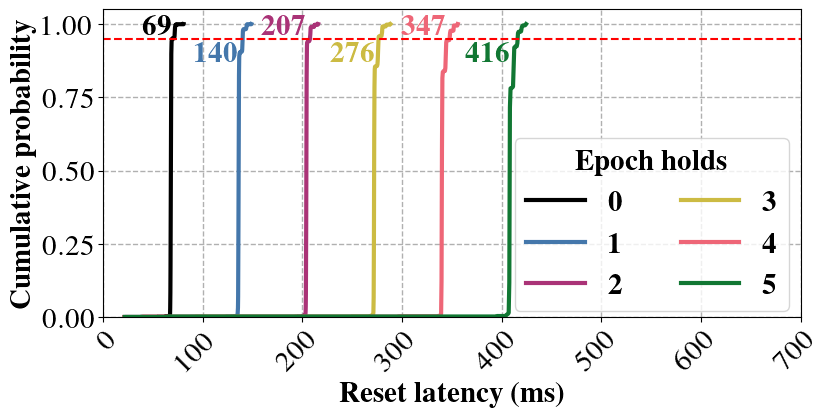

In [13]:
# Plot CDFs
fig, ax = plt.subplots()

# Plot line for line...
colors = ["#000000", "#4477AB", MAGENTA, OLIVE, ROSE, GREEN]
ite=0
for prio in prio_run_dat:
    # plot line
    da = prio
    count, bins_count = np.histogram(da, bins=len(da)) 
    pdf = count / sum(count) 
    cdf = np.cumsum(pdf) 
    plt.plot(bins_count[1:], cdf, label=r"\textbf{" + str(ite) + "}",color=colors[ite], linewidth=3)
    ite = ite + 1

    # Annotate
    txt = r'\textbf{' + str(round(np.percentile(prio, 95, axis=0, overwrite_input=True),1))[:-2] + '}'
    xoffset = -22 if ite == 1 else -35
    yoffset = -16 if ite % 2 == 0 else 3
    xoffset = xoffset - 3 if ite == 6 else xoffset
    ax.annotate(txt,
                xy=(np.percentile(prio, 95, axis=0, overwrite_input=True), 0.95), xycoords='data',
                xytext=(xoffset, yoffset), textcoords='offset points', color=colors[ite-1])

    # Set plot to look nice
plt.legend(title=r"\textbf{Epoch holds}", loc=(0.59,0.02),ncol=2)
ax.set_ylim(bottom=0, top=1.05)
ax.set_xlim(left=0, right=384)
ax.yaxis.set_ticks([0,0.25,0.5,0.75,1])
ax.xaxis.set_ticks(np.arange(0, 800, 100))
plt.setp(ax.get_xticklabels(),
            rotation=45,
            ha="right",
            rotation_mode="anchor")
ax.set_ylabel(r'\textbf{Cumulative probability}')
ax.set_xlabel(r'\textbf{Reset latency (ms)}')
fig.set_figwidth(9) 
fig.set_figheight(4)
ax.grid(which='major', linestyle='dashed', linewidth='1')

# P-95 line
plt.axhline(y = 0.95, color = 'r', linestyle = '--') 

plt.savefig(f"./plots/cdf-reset-epoch-holds.pdf", bbox_inches="tight")

In [14]:
print("CDF summary:")
print('max epoch holds of 0: ', str(round(np.percentile(prio_run_dat[0], 95, axis=0, overwrite_input=True),1)),'ms' )
print('max epoch holds of 1:', str(round(np.percentile(prio_run_dat[1], 95, axis=0, overwrite_input=True),1)),'ms' )
print('max epoch holds of 2:', str(round(np.percentile(prio_run_dat[2], 95, axis=0, overwrite_input=True),1)),'ms' )
print('max epoch holds of 3:', str(round(np.percentile(prio_run_dat[3], 95, axis=0, overwrite_input=True),1)),'ms' )
print('max epoch holds of 4:', str(round(np.percentile(prio_run_dat[4], 95, axis=0, overwrite_input=True),1)),'ms' )
print('max epoch holds of 5:', str(round(np.percentile(prio_run_dat[5], 95, axis=0, overwrite_input=True),1)),'ms' )

CDF summary:
max epoch holds of 0:  69.3 ms
max epoch holds of 1: 140.1 ms
max epoch holds of 2: 207.6 ms
max epoch holds of 3: 276.5 ms
max epoch holds of 4: 347.7 ms
max epoch holds of 5: 416.0 ms


# Figure 9

-0.004482470499380673
0.022071617529735903
0.03440529672924557
0.0041822286903447255
0.006165512519683915
0.017957045339567775
0.017544425626546324
-0.02453987730061352
-0.02139037433155082
-0.055299539170506964
0.01976284584980239
0.056872037914691996
0.029197080291970625
0.0
Interference RMS 0% - 50% 0.17472965865646023
Interference RMS 0% - 50% 0.111384018601701
Interference RMS 0% - 50% 0.09403582219281831
Interference RMS 0% - 50% 0.01658340328263374
[51.735285714, 79.085375, 90.16653571399999, 99.10775, 101.092107143, 101.352339286, 102.192464286] [50.655714286000006, 78.54, 89.361178571, 112.40660241, 132.363462185, 135.941663866, 138.478697479]


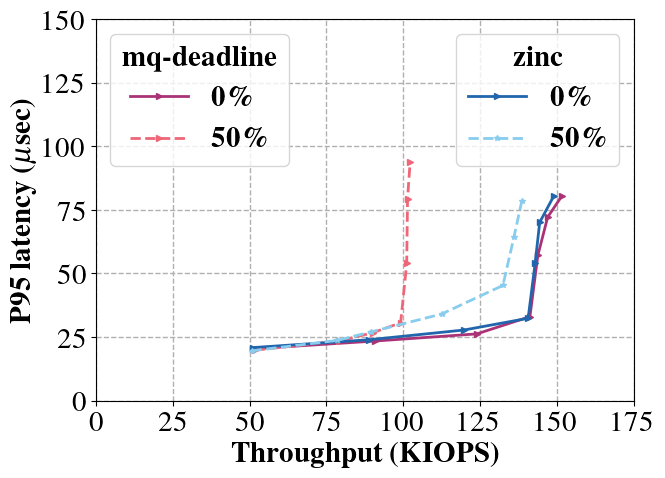

In [15]:
write_baseline_iops = [None] * len(queue_depths)
write_baseline_lat = [None] * len(queue_depths)
reset_baseline_iops = [None] * len(queue_depths)
reset_baseline_lat = [None] * len(queue_depths)
mqddl_iops = [None] * len(queue_depths)
mqddl50_iops = [None] * len(queue_depths)
mqddl_lat = [None] * len(queue_depths)
mqddl50_lat = [None] * len(queue_depths)

parse_write_baseline(write_baseline_iops, write_baseline_lat, mqddl_iops, mqddl_lat, mqddl50_iops, mqddl50_lat,
                     mqddl_reset_iops, mqddl_reset_lat, zinc_baseline_iops, zinc_baseline_lat)
parse_reset_baseline(reset_baseline_iops, reset_baseline_lat)

write_iops = [None] * len(queue_depths)
write_lat = [None] * len(queue_depths)
reset_iops = [None] * len(queue_depths)
reset_lat = [None] * len(queue_depths)

conf_value = data['reset_lat_64-write_ratio_20000']

for key, value in conf_value.items():
    if conf_key == "baseline":
        continue
    elif "reset_limit_val" in key or "write_ratio_val" in key:
        continue
    else:
        head, tail = os.path.split(key)
        numjobs = int(re.search(r'\d+', tail).group())
        x = numjobs - 1
        write_iops[x] = value["jobs"][2]["finish"]["iops_mean"]/1000
        write_lat[x] = value["jobs"][2]["finish"]["clat_ns"]["percentile"]["95.000000"]/1000
        reset_iops[x] = value["jobs"][1]["ZNS Reset"]["iops_mean"]
        reset_lat[x] = value["jobs"][1]["ZNS Reset"]["clat_ns"]["percentile"]["95.000000"]/1000

fig, ax = plt.subplots()

p1, = ax.plot(mqddl_iops, mqddl_lat, markersize=4,
        marker='>', label=r"\textbf{0\% mqddl}", color=MAGENTA, linewidth='2')
p2, = ax.plot(mqddl50_iops, mqddl50_lat, markersize=4,
        marker='>', label=r"\textbf{50\% mqddl}", color=ROSE,linestyle='--', linewidth='2')
p3, = ax.plot(zinc_baseline_iops, zinc_baseline_lat,
        markersize=4, marker='>', label=r"\textbf{0\% zinc}", color='#2166AC', linewidth='2')
p4, = ax.plot(write_iops, write_lat, markersize=4,
        marker='*', label=r"\textbf{50\% zinc}", color=CYAN,linestyle='--', linewidth='2')

fig.tight_layout()
ax.grid(which='major', linestyle='dashed', linewidth='1')
ax.set_axisbelow(True)
l1 = ax.legend([p1,p2], [r"\textbf{0\%}",r"\textbf{50\%}"], loc='upper left', ncol=1, title=r"\textbf{mq-deadline}")
l2 = ax.legend([p3,p4], [r"\textbf{0\%}",r"\textbf{50\%}"], loc='upper right', ncol=1, title=r"\textbf{zinc}")
plt.gca().add_artist(l1)

ax.xaxis.set_ticks(np.arange(0, 200, 25))
ax.yaxis.set_ticks(np.arange(0, 155, 25))
ax.set_ylim(bottom=0,top=150)
ax.set_xlim(left=0,right=175)

ax.set_ylabel(r"\textbf{P95 latency ($\mu$sec)}")
ax.set_xlabel(r"\textbf{Throughput (KIOPS)}")
plt.savefig(f"./plots/micro-zinc-optimal.pdf", bbox_inches="tight")

for i in range(len(mqddl_iops)):
        print( (mqddl_iops[i] - zinc_baseline_iops[i]) / zinc_baseline_iops[i])
        
for i in range(len(mqddl_lat)):
        print( (mqddl_lat[i] - zinc_baseline_lat[i]) / zinc_baseline_lat[i])
        
        
print(f"Interference RMS 0% - 50% {get_interference_rms(mqddl_iops, mqddl50_iops, mqddl_lat, mqddl50_lat)}")
print(f"Interference RMS 0% - 50% {get_interference_rms(mqddl_iops, write_iops, mqddl_lat, write_lat)}")


print(f"Interference RMS 0% - 50% {get_interference_rms([78.79], [72.58], [12.23], [13.54])}")
print(f"Interference RMS 0% - 50% {get_interference_rms([78.19], [80.00], [13.29], [13.24])}")

print(mqddl50_iops, write_iops)

# TABLE IV plotted

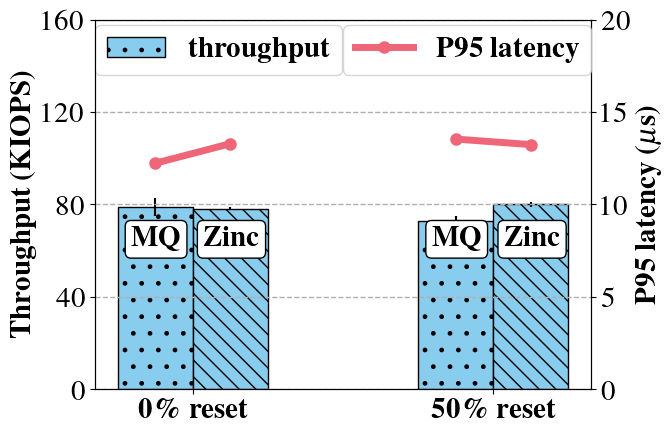

In [16]:
fig, ax = plt.subplots()

HBAR = ax.bar([1, 2], 
              [78.79,72.85],  
              yerr=[3.97, 2.12], 
              color=[CYAN,CYAN], 
              width=0.25, 
              align='center', 
              edgecolor = "black", 
              ecolor="black", label=r'\textbf{throughput}', hatch = r'.')

HBAR = ax.bar([1.25, 2.25], 
              [78.19,80.00],  
              yerr=[0.58, 1.25], 
              color=[CYAN,CYAN], 
              width=0.25, 
              align='center', 
              edgecolor = "black", 
              ecolor="black", hatch = r'\\')

ax.yaxis.set_ticks(np.arange(0, 200, 40))

ax.set_ylim(bottom=0,top=160)
ax.set_xticks([1.125,2.125], labels=[r'\textbf{0\% reset}', r'\textbf{50\% reset}'])
ax.set_ylabel(r"\textbf{Throughput (KIOPS)}")
plt.legend(ncol=1, loc=(0,0.85))


ax.annotate(r'\textbf{MQ}',
                xy=(0.92,50), xycoords='data',
                xytext=(0, 20), textcoords='offset points',
            bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=1))
ax.annotate(r'\textbf{Zinc}',
                xy=(1.16,50), xycoords='data',
                xytext=(0, 20), textcoords='offset points',
            bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=1))

ax.annotate(r'\textbf{MQ}',
                xy=(1.92,50), xycoords='data',
                xytext=(0, 20), textcoords='offset points',
            bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=1))
ax.annotate(r'\textbf{Zinc}',
                xy=(2.16,50), xycoords='data',
                xytext=(0, 20), textcoords='offset points',
            bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=1))

ax2 = ax.twinx() 
ax2.plot([1,1.25], [12.23, 13.29],
        markersize=8, marker='o', label=r"\textbf{P95 latency}", color=ROSE, linewidth='5')
ax2.plot([2,2.25], [13.54, 13.24],
        markersize=8, marker='o', color=ROSE, linewidth='5')
ax2.set_ylim(bottom=0,top=20)
ax2.set_ylabel(r"\textbf{P95 latency ($\mu$s)}")
ax2.grid(which='major', linestyle='dashed', linewidth='1')

ax2.legend(loc=(0.5,0.85))
plt.savefig(f"./plots/macro-zinc-optimal.pdf", bbox_inches="tight")